In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=24

train_cardiac_total=pd.read_csv("mimic_dead_vital_sign_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_dead_vital_sign_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_dead_baseline_total_v2.csv")

#eicu_cardiac_total=pd.read_csv("eicu_total_"+str(T)+"hours.csv")

total_train=24100 #control+event
total_test=6025 #control+event
train_control=21160 #control


var=6
random=32
smote_ratio=1
near_ratio=1

EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_nr=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
y_train_no_smote=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels
y_test_log=df_test_base['eventV3'].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

x_train_base_no_smote=minmax_scale.fit_transform(train_features)

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

x_train_lstm_nr, y_train_nr = nr.fit_sample(train_cardiac_total, y_train_nr.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

print('timeline_no_smote:',x_train_lstm_no_smote.shape)
print('baseline_no_smote:',x_train_base_no_smote.shape)
print('label_no_smote:',y_train_no_smote.shape)


print('timeline_nr:',x_train_lstm_nr.shape)
print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


Using TensorFlow backend.


timeline: (24100, 144)
baseline: (24100, 70)
timeline: (42320, 24, 6)
baseline: (42320, 70)
label: (42320,)
timeline: (6025, 24, 6)
baseline: (6025, 70)
label: (6025, 1)
timeline_no_smote: (24100, 24, 6)
baseline_no_smote: (24100, 70)
label_no_smote: (24100, 1)
timeline_nr: (5880, 24, 6)
label_nr: (5880,)


In [2]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(42320, 24, 6)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 8)             480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 8)             0         
_____________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 31s - loss: 0.4461 - accuracy: 0.8168 - f1_m: 0.7214 - precision_m: 0.8349 - val_loss: 0.6453 - val_accuracy: 0.6367 - val_f1_m: 0.7749 - val_precision_m: 1.0000
Epoch 3/3
 - 30s - loss: 0.4267 - accuracy: 0.8263 - f1_m: 0.7399 - precision_m: 0.8371 - val_loss: 0.6659 - val_accuracy: 0.6337 - val_f1_m: 0.7727 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 95.13 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 80.7065%
test accuracy = 92.8963%
test error = 428 out of 6025 examples


In [3]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 1 1 0]


In [4]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5090  199]
 [ 229  507]]
accuracy: 0.9289626556016598
specificity: 0.96237474002647
sensitivity: 0.688858695652174
ppv: 0.7181303116147308
npv: 0.9569467945102463


<Figure size 432x288 with 0 Axes>

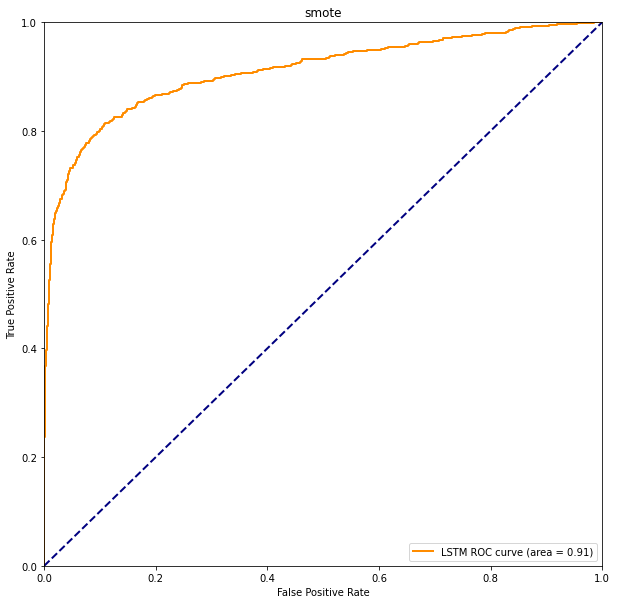

In [5]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [6]:
print(x_train_lstm_nr.shape)
print(y_train_nr.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_nr.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_nr = Sequential()

model_nr.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())

model_nr.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_nr.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_nr.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_nr.fit(x_train_lstm_nr, y_train_nr,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_nr.evaluate(x_train_lstm_nr, y_train_nr,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_nr.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(5880, 24, 6)
(5880,)
layers=[8, 8, 8, 1], train_examples=5880, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 24, 8)             480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 8)             0         
________________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 4s - loss: 0.7039 - accuracy: 0.6016 - f1_m: 0.1825 - precision_m: 0.3659 - val_loss: 0.9769 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/3
 - 4s - loss: 0.6875 - accuracy: 0.6233 - f1_m: 0.1000 - precision_m: 0.3069 - val_loss: 0.9706 - val_accuracy: 0.0102 - val_f1_m: 0.0196 - val_precision_m: 0.2973
-----------------------------------------------------------------
Training was completed in 17.01 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.4252%
test accuracy = 87.8672%
test error = 731 out of 6025 examples


In [7]:
y_pred_nr= model_nr.predict(x_test_lstm)

predict_test_nr=[]
for i in range(y_pred_nr.shape[0]): 
    if y_pred_nr[i]>0.5:
        predict_test_nr.append(1)
    else:
        predict_test_nr.append(0)
predict_test_nr = np.array(predict_test_nr)
print(predict_test_nr)

[0 0 0 ... 0 0 0]


In [8]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_nr,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_nr)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5289    0]
 [ 731    5]]
accuracy: 0.8786721991701245
specificity: 1.0
sensitivity: 0.006793478260869565
ppv: 1.0
npv: 0.8785714285714286


<Figure size 432x288 with 0 Axes>

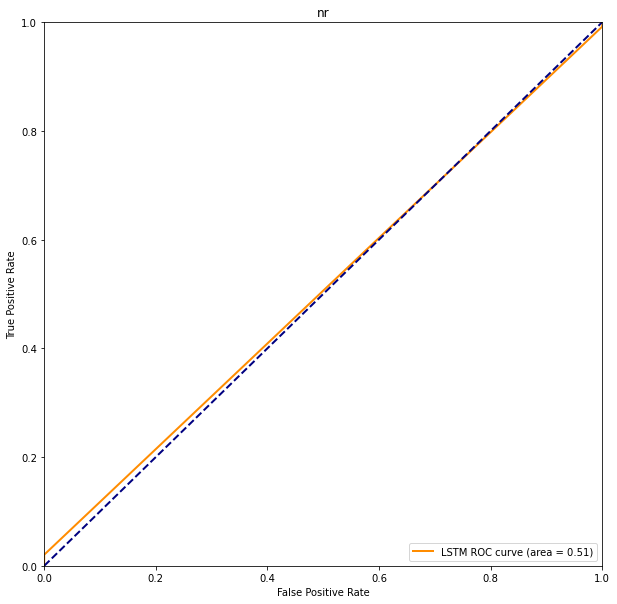

In [9]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_nr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('nr')
plt.legend(loc="lower right")

plt.show()

In [10]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 24, 6)
(8464, 24, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 24, 8)             480       
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 8)             32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 8)             544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 32s - loss: 0.4894 - accuracy: 0.7876 - f1_m: 0.7686 - precision_m: 0.8398 - val_loss: 0.3905 - val_accuracy: 0.8448 - val_f1_m: 0.4431 - val_precision_m: 0.5019
Epoch 3/3
 - 35s - loss: 0.4560 - accuracy: 0.8060 - f1_m: 0.7911 - precision_m: 0.8524 - val_loss: 0.3714 - val_accuracy: 0.8498 - val_f1_m: 0.4336 - val_precision_m: 0.5019
-----------------------------------------------------------------
Training was completed in 103.58 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 83.2112%
test accuracy = 91.3859%
test error = 519 out of 6025 examples


In [11]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 0 1 0]


In [12]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4943  346]
 [ 173  563]]
specificity: 0.934581206277179
sensitivity: 0.7649456521739131
ppv: 0.6193619361936193
npv: 0.9661845191555903


In [13]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 24, 6)
(8464, 24, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 35s - loss: 0.4987 - accuracy: 0.7820 - f1_m: 0.7609 - precision_m: 0.8391 - val_loss: 0.4373 - val_accuracy: 0.8144 - val_f1_m: 0.4186 - val_precision_m: 0.5017
Epoch 3/3
 - 35s - loss: 0.4697 - accuracy: 0.7975 - f1_m: 0.7806 - precision_m: 0.8430 - val_loss: 0.4011 - val_accuracy: 0.8339 - val_f1_m: 0.4259 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 111.82 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 83.4889%
test accuracy = 89.7593%
test error = 617 out of 6025 examples


In [14]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[0 0 0 ... 0 1 0]


In [15]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4869  420]
 [ 197  539]]
specificity: 0.9205899035734544
sensitivity: 0.7323369565217391
ppv: 0.5620437956204379
npv: 0.9611133043821556


In [16]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 24, 6)
(8464, 24, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_14 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 34s - loss: 0.4584 - accuracy: 0.8083 - f1_m: 0.7922 - precision_m: 0.8581 - val_loss: 0.3989 - val_accuracy: 0.8286 - val_f1_m: 0.4103 - val_precision_m: 0.5017
Epoch 3/3
 - 34s - loss: 0.4268 - accuracy: 0.8194 - f1_m: 0.8050 - precision_m: 0.8701 - val_loss: 0.4083 - val_accuracy: 0.8198 - val_f1_m: 0.3977 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 109.23 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 81.8407%
test accuracy = 94.2905%
test error = 344 out of 6025 examples


In [17]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 0 ... 1 1 0]


In [18]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5168  121]
 [ 223  513]]
specificity: 0.9771223293628285
sensitivity: 0.6970108695652174
ppv: 0.8091482649842271
npv: 0.95863476163977


In [19]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 24, 6)
(8464, 24, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 34s - loss: 0.4588 - accuracy: 0.8063 - f1_m: 0.7850 - precision_m: 0.8743 - val_loss: 0.6506 - val_accuracy: 0.7306 - val_f1_m: 0.4775 - val_precision_m: 0.5010
Epoch 3/3
 - 34s - loss: 0.4400 - accuracy: 0.8140 - f1_m: 0.7941 - precision_m: 0.8801 - val_loss: 0.4024 - val_accuracy: 0.8229 - val_f1_m: 0.4527 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 108.46 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 82.842%
test accuracy = 82.2075%
test error = 1072 out of 6025 examples


In [20]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[0 0 0 ... 1 1 1]


In [21]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4312  977]
 [  95  641]]
specificity: 0.8152769899792022
sensitivity: 0.8709239130434783
ppv: 0.396168108776267
npv: 0.9784433855230316


In [22]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 24, 6)
(8464, 24, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=6025
batch = 32, timesteps = 24, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 24, 8)             480       
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 8)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 24, 8)             544       
_________________________________________________________________
dropout_20 (Dropout)         (None, 24, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 34s - loss: 0.5091 - accuracy: 0.7743 - f1_m: 0.7558 - precision_m: 0.8181 - val_loss: 0.4567 - val_accuracy: 0.7852 - val_f1_m: 0.4575 - val_precision_m: 0.5014
Epoch 3/3
 - 34s - loss: 0.4774 - accuracy: 0.7922 - f1_m: 0.7778 - precision_m: 0.8309 - val_loss: 0.4637 - val_accuracy: 0.7888 - val_f1_m: 0.3825 - val_precision_m: 0.5019
-----------------------------------------------------------------
Training was completed in 108.12 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 79.7495%
test accuracy = 91.4025%
test error = 518 out of 6025 examples


In [23]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 0 0 ... 0 0 0]


In [24]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5014  275]
 [ 243  493]]
specificity: 0.9480052940064284
sensitivity: 0.6698369565217391
ppv: 0.6419270833333334
npv: 0.953775917823854


In [25]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [26]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 0 1 0]


In [27]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[4999  290]
 [ 171  565]]
specificity: 0.9451692191340518
sensitivity: 0.7676630434782609
ppv: 0.6608187134502924
npv: 0.9451692191340518


<Figure size 432x288 with 0 Axes>

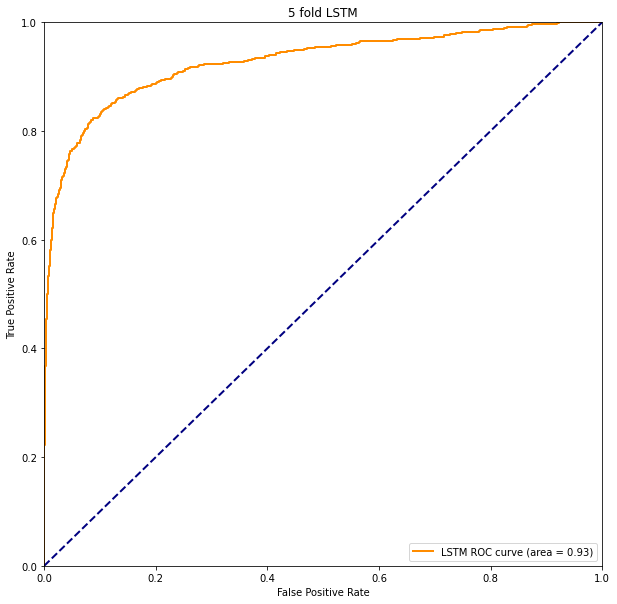

In [28]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [29]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.92
AUC : 0.93
Sensitivity : 0.77
Specificity :0.95
80.27919126532929


In [30]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import model_selection

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest = forest.fit(x_train_base, y_train)

prob_predict_y_validation1 = forest.predict_proba(x_train_base)#给出带有概率值的结果，每个点所有label的概率和为1
prob_predict_y_validation = forest.predict_proba(x_test_base)#给出带有概率值的结果，每个点所有label的概率和为1


y_score = prob_predict_y_validation[:, 1]
# 預測
predict_train_rf = prob_predict_y_validation1[:, 1]

test_y_predicted = forest.predict(x_test_base)

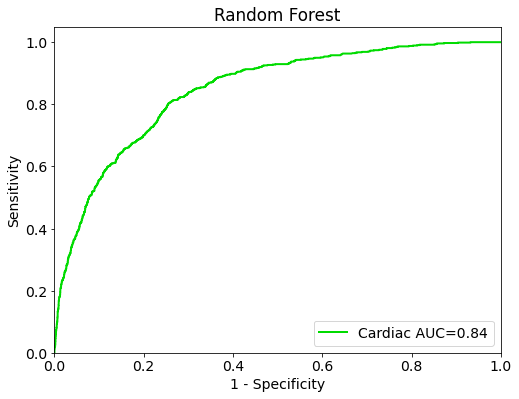

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Random Forest')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [32]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(total_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

Accuracy  = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])   

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Accuracy : %0.2f' %Accuracy)  #Accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)



Confusion Matrix : 
 [[4447  842]
 [ 251  485]]
Accuracy : 0.82
AUC : 0.84
Sensitivity : 0.66
Specificity :0.84


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(x_train_base, y_train)

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [34]:
predict_train_logistic_result = logreg.predict_proba(x_train_base)

predict_train_logistic = predict_train_logistic_result[:, 1]

logreg_test_y_predicted = logreg.predict_proba(x_test_base)

log_y_score = logreg_test_y_predicted[:, 1]

predict_test=[]
for i in range(log_y_score.shape[0]): 
    if log_y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_log,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.796349
Sensitivity : 0.73
Specificity :0.81


predict,0,1
label,,
0,4262,1027
1,200,536


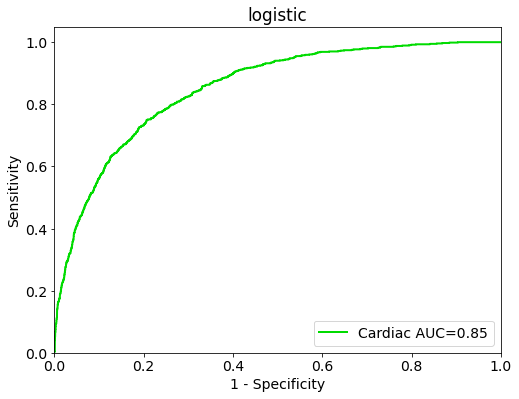

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('logistic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [36]:
print(predict_train_logistic)
print(predict_train_lstm)

stacking=np.append(predict_train_logistic, predict_train_lstm)
x_train_stacking=np.array(stacking).reshape(x_train_lstm.shape[0],2, order='F') #轉維

from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm = svm.SVC(kernel='linear',probability=True)
svm.fit(x_train_stacking,y_train)

print(x_train_stacking.shape)
print(y_train.shape)

print(log_y_score.shape)#logistic test 機率
print(y_pred.shape)#lstm test 機率 
print(y_score.shape)#Rf test 機率

stacking_test=np.append(y_pred, log_y_score)
x_test_stacking=np.array(stacking_test).reshape(total_test,2, order='F') #轉維


[0.28924532 0.04278652 0.30489996 ... 0.80104575 0.86632482 0.35890906]
[0.12164613 0.11813436 0.27109975 ... 0.81033164 0.18001767 0.7841495 ]
(42320, 2)
(42320,)
(6025,)
(6025,)
(6025,)


In [37]:
predict=svm.predict(x_test_stacking)
predict_pro_stacking=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_test, predict)
precision  = metrics.precision_score(y_test, predict)

print(accuracy)
print(precision)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_stacking=predict_pro_stacking[:,1:2]

#################92個test ca 輸出#####################
#test=pd.DataFrame(predict[4689:])
#test.to_csv('24hour_ca.csv', index=False)
####################################### predict_pro_stacking

0.8409958506224067
0.42560321715817695


In [38]:
predict_test_stacking=[]
for i in range(predict_pro_stacking.shape[0]): 
    if predict_pro_stacking[i]>0.5:
        predict_test_stacking.append(1)
    else:
        predict_test_stacking.append(0)
predict_test_stacking = np.array(predict_test_stacking)


In [39]:
pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_stacking)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)
flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro_stacking[i]>0.5:
            total_predict=total_predict+predict_pro_stacking[i]
            flag=flag+1
print(flag)  #score

print(y_test_1D)

Confusion Matrix : 
 [[4423  866]
 [  99  637]]
specificity: 0.8362639440347892
sensitivity: 0.8654891304347826
ppv: 0.42381902860944776
npv: 0.8362639440347892
1503
[0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

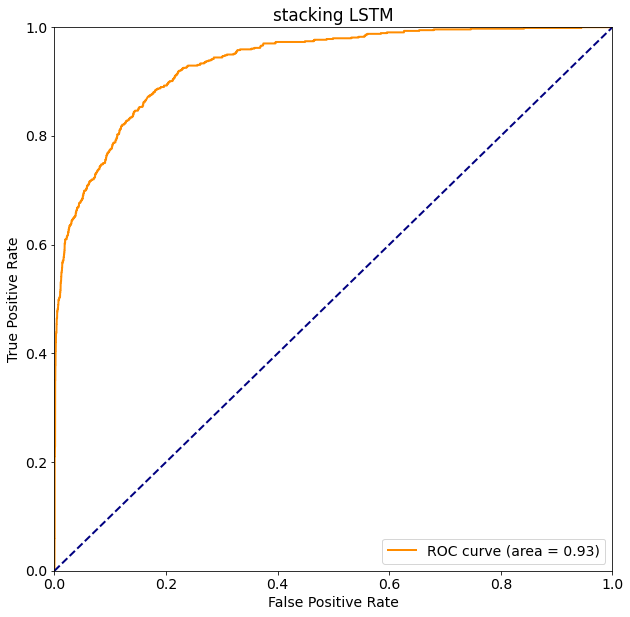

In [40]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, predict_pro_stacking) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM')
plt.legend(loc="lower right")

plt.show()

In [41]:
print('Accuracy : %0.2f' %accuracy)  #Accuracy
print('precision : %0.2f' %precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

Accuracy : 0.84
precision : 0.43
AUC : 0.93
Sensitivity : 0.87
Specificity :0.84
[84.22154172]


In [42]:
print(x_train_stacking)  #y_test # y_train

[[0.28924532 0.12164613]
 [0.04278652 0.11813436]
 [0.30489996 0.27109975]
 ...
 [0.80104575 0.81033164]
 [0.86632482 0.18001767]
 [0.35890906 0.78414953]]


In [43]:
print(x_test_stacking)

[[0.11174593 0.4176102 ]
 [0.10927875 0.37011429]
 [0.14103432 0.10843045]
 ...
 [0.48433885 0.81297305]
 [0.61448044 0.20908676]
 [0.47463217 0.51848652]]


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn import model_selection

gbm = xgb.XGBRegressor()

xgb_params = {
'learning_rate': [0.1,0.2,0.5],
'n_estimators': [30,50,100],
'max_depth': [5,10,20],
 'alpha': [0.4,0.6],
 }

xg_reg = model_selection.GridSearchCV(gbm, xgb_params, cv=5)
xg_reg.fit(x_train_stacking,y_train)

y_pred_xgb = xg_reg.predict(x_test_stacking)


In [45]:
predict_test_xgb=[]
for i in range(y_pred_xgb.shape[0]): 
    if y_pred_xgb[i]>0.5:
        predict_test_xgb.append(1)
    else:
        predict_test_xgb.append(0)
predict_test_xgb = np.array(predict_test_xgb)

pd.crosstab(y_test_1D,predict_test_xgb,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
print('accuracy :%0.2f' % accuracy)


Confusion Matrix : 
 [[4262 1027]
 [ 200  536]]
Sensitivity : 0.73
Specificity :0.81
accuracy :0.80


In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
#'n_estimators': [5],
#'max_depth': [5]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest_fit=forest.fit(x_train_stacking,y_train)

prob_predict_y_validation_stacking = forest.predict_proba(x_test_stacking)#给出带有概率值的结果，每个点所有label的概率和为1
y_score_stacking = prob_predict_y_validation_stacking[:, 1]


In [47]:
predict_test=[]
for i in range(y_score_stacking.shape[0]): 
    if y_score_stacking[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

fpr,tpr,roc_auc = roc_curve_and_score(y_test, y_score_stacking) ###計算真正率和假正率

print('AUC : %0.2f' % roc_auc)  #AUC

print('accuracy :%0.2f' % accuracy)

print(forest.best_params_)
print(forest.best_score_)

Confusion Matrix : 
 [[4425  864]
 [  94  642]]
Sensitivity : 0.87
Specificity :0.84
AUC : 0.93
accuracy :0.84
{'max_depth': 7, 'n_estimators': 15}
0.8953213610586012


In [48]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train_stacking, y_train)

KNeighborsClassifier(n_neighbors=2)

In [49]:
nei_test_y_predicted = neigh.predict(x_test_stacking)
predict_test=[]
for i in range(nei_test_y_predicted.shape[0]): 
    if nei_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.863071
Sensitivity : 0.77
Specificity :0.88


predict,0,1
label,,
0,4636,653
1,172,564


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(x_train_stacking, y_train)
#log_test_y_predicted = logreg.fit(x_train_stacking, y_train).decision_function(X_test)

LogisticRegression()

In [51]:
logreg_test_y_predicted_pro = logreg.predict_proba(x_test_stacking)

log_score = logreg_test_y_predicted_pro[:, 1]

predict_test=[]
for i in range(log_score.shape[0]): 
    if log_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.841992
Sensitivity : 0.87
Specificity :0.84


predict,0,1
label,,
0,4432,857
1,95,641


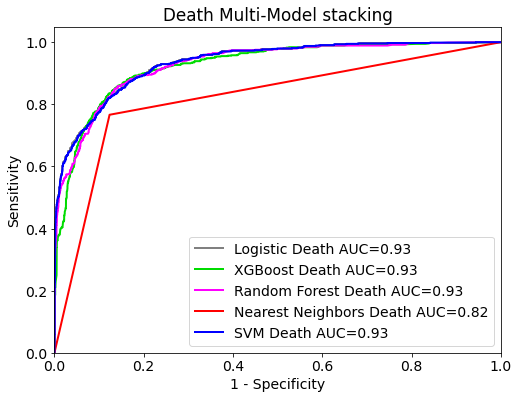

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

#plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_score)
plt.plot(fpr, tpr, color='gray', lw=2,
         label='Logistic Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='XGBoost Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score_stacking)
plt.plot(fpr, tpr, color='#ff00ff', lw=2,
         label='Random Forest Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)
plt.plot(fpr, tpr, color='red', lw=2,
         label='Nearest Neighbors Death AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, predict_pro_stacking)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SVM Death AUC={0:.2f}'.format(roc_auc))

plt.title('Death Multi-Model stacking')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [53]:
y_score_stacking

array([0.14930716, 0.11003945, 0.01785298, ..., 0.95259268, 0.2955731 ,
       0.69889283])

In [54]:
predict_cxr=pd.read_csv("neur_test_all_patients_dead.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)


for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

6025


In [55]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('accuracy : %0.2f' % accuracy)

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


Confusion Matrix : 
 [[4443  846]
 [  90  646]]
accuracy : 0.84
Sensitivity : 0.88
Specificity :0.84


<Figure size 432x288 with 0 Axes>

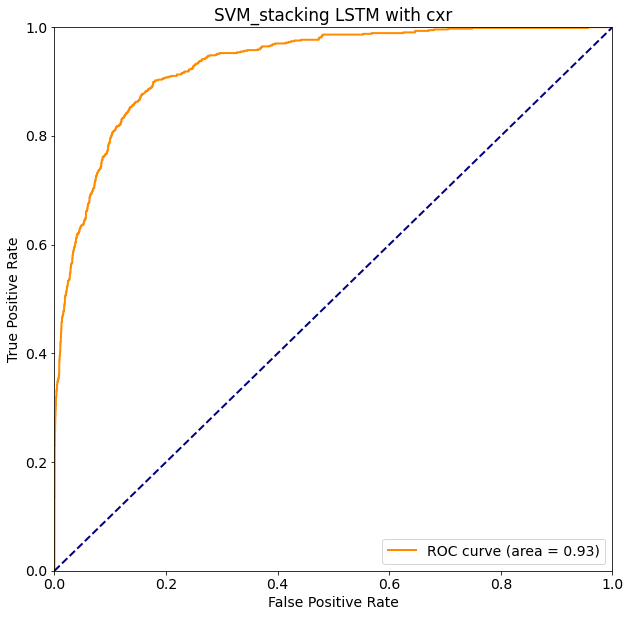

In [56]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [57]:
predict_cxr=pd.read_csv("neur_test_all_patients_dead.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_lr=[]

for idx, i in enumerate(log_score):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_lr.append(log_score[idx])
    else:
        y_predict_combine_lr.append((log_score[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_lr=np.array(y_predict_combine_lr)
print(y_predict_combine_lr.size)

6025


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [58]:
predict_test_combine=[]
for i in range(y_predict_combine_lr.shape[0]): 
    if y_predict_combine_lr[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('accuracy : %0.2f' % accuracy)

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


Confusion Matrix : 
 [[4451  838]
 [  88  648]]
accuracy : 0.85
Sensitivity : 0.88
Specificity :0.84


<Figure size 432x288 with 0 Axes>

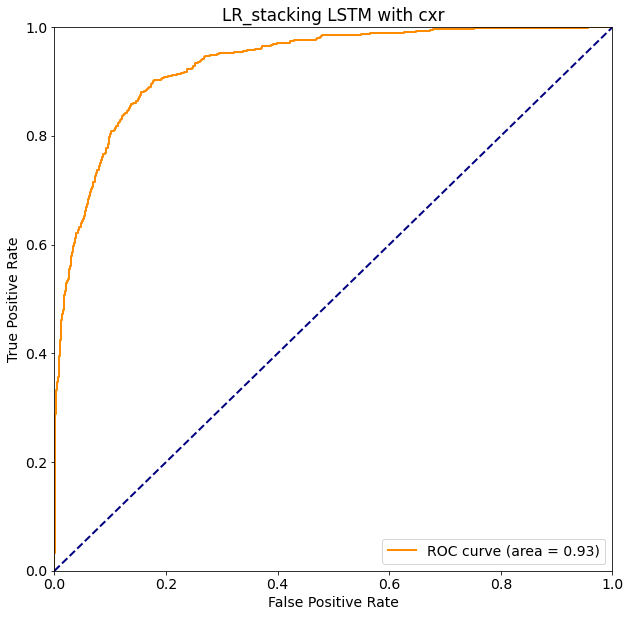

In [59]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine_lr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

0.11726817564473128


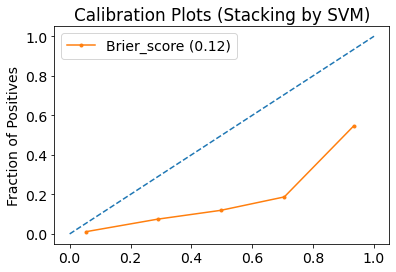

In [60]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, predict_pro_stacking)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, predict_pro_stacking)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by SVM)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

0.11517966039824014


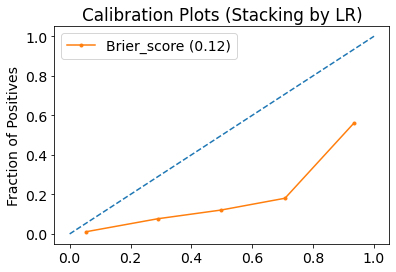

In [61]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, log_score)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, log_score)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by LR)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

In [62]:
#test_avg=pd.DataFrame(x_test_stacking)
#test_avg.to_csv('test_avg.csv', index=False)

In [63]:
#predict_pro_stacking_pri=pd.DataFrame(predict_pro_stacking)
#predict_pro_stacking_pri.to_csv('predict_pro_stacking_pri.csv', index=False)
